In [10]:
import numpy as np
import scipy.signal as signal
import torch
import gc

class IIR2FilterTorch(torch.nn.Module):           
    
    def createCoeffs(self,order=3,cutoff=0.9,filterType='lowpass',design='bessel',rp=1,rs=1,fs=1):
        
        #defining the acceptable inputs for the design and filterType params
        self.designs = ['butter','cheby1','cheby2','bessel']
        self.filterTypes1 = ['lowpass','highpass','Lowpass','Highpass','low','high']
        self.filterTypes2 = ['bandstop','bandpass','Bandstop','Bandpass']
        
        #Error handling: other errors can arise too, but those are dealt with 
        #in the signal package.
        self.isThereAnError = 1 #if there was no error then it will be set to 0
        self.COEFFS = [0] #with no error this will hold the coefficients
        
        if design not in self.designs:
            print('Gave wrong filter design! Remember: butter, cheby1, cheby2.')
        elif filterType not in self.filterTypes1 and filterType not in self.filterTypes2:
            print('Gave wrong filter type! Remember: lowpass, highpass', 
                  ', bandpass, bandstop.')
        elif fs < 0:
            print('The sampling frequency has to be positive!')
        else:
            self.isThereAnError = 0
        
        #if fs was given then the given cutoffs need to be normalised to Nyquist
        if fs !=1:
            if isinstance(cutoff, float):
                cutoff/(fs*2)
            else:
                for i in range(len(cutoff)):
                    cutoff[i] = cutoff[i]/(fs*2)
        
        if design == 'butter' and self.isThereAnError == 0:
            self.COEFFS = signal.butter(order,cutoff,filterType,output='sos')
        elif design == 'cheby1' and self.isThereAnError == 0:
            self.COEFFS = signal.cheby1(order,rp,cutoff,filterType,output='sos')
        elif design == 'cheby2' and self.isThereAnError == 0:
            self.COEFFS = signal.cheby2(order,rs,cutoff,filterType,output='sos')
        elif design == 'bessel' and self.isThereAnError == 0:
            self.COEFFS = signal.bessel(order,cutoff,filterType,output='sos')
        
        return self.COEFFS
        
    def __init__(self,shape,order,cutoff,filterType='lowpass',design='bessel',device='cpu',rp=0.1,rs=1,fs=1):
        super().__init__()
        self.device = torch.device(device)
        self.COEFFS = self.createCoeffs(order,cutoff,filterType,design,rp,rs,fs)
        self.shape = shape
        self.reset()
        
    def reset(self):
        self.sos_xz1 = [torch.zeros(self.shape).to(self.device) for _ in self.COEFFS]
        self.sos_xz2 = [torch.zeros(self.shape).to(self.device) for _ in self.COEFFS]
        self.sos_yz1 = [torch.zeros(self.shape).to(self.device) for _ in self.COEFFS]
        self.sos_yz2 = [torch.zeros(self.shape).to(self.device) for _ in self.COEFFS]
        
        torch.cuda.empty_cache()
        gc.collect()
       
    def forward(self,input):
        prev_stage_output = input
        
        for i in range(len(self.COEFFS)):
            
            numerators = self.COEFFS[i][0:3]
            denominators = self.COEFFS[i][3:6]
            
            output = numerators[0] * prev_stage_output + numerators[1] * self.sos_xz1[i] + numerators[2] * self.sos_xz2[i] - (denominators[1] * self.sos_yz1[i] + denominators[2] * self.sos_yz2[i])
            
            self.sos_xz2[i] = self.sos_xz1[i]
            self.sos_xz1[i] = prev_stage_output
            
            self.sos_yz2[i] = self.sos_yz1[i]
            self.sos_yz1[i] = output
            
            prev_stage_output = output
        
        return prev_stage_output
    

In [34]:
a = IIR2FilterTorch((1,2), 5, 1/4000)

In [31]:
a(torch.Tensor([[1,2]]))

tensor([[1.0255e-16, 2.0509e-16]])

In [36]:
torch.cuda.memory_cached()

0

In [27]:
a.reset()

In [29]:
import tensorflow as tf
tf.enable_eager_execution()
import sys
sys.path.append('../')
from utils.tf_iir_upsampler import IIR2Filter

b = IIR2Filter((1,2),5,1/4000)

In [32]:
b.filter(np.array([[1,2]]))

<tf.Tensor: id=289, shape=(1, 2), dtype=float64, numpy=array([[1.02547289e-16, 2.05094579e-16]])>

In [1]:
import pixiedust

import tensorflow as tf
tf.enable_eager_execution()
import sys
#sys.path.append('../')
sys.path.append('../tf_env/')
from tf_iir_upsampler import IIR2Filter
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np

import sys
#sys.path.append('../tf_env/')
#sys.path.append('../')
from quantum_control import QuantumControl
#from transmon_env import TransmonEnv

Pixiedust database opened successfully


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
../tf_env/quantum_control.py:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(a.shape[0] == b.shape[0], 'batch size mismatch')


In [2]:
# env = TransmonEnv(nmax=5, Q=1e3, T1=1e9,
#                  Zr=50, extFlux=0., 
#                  extVoltage=0., omega=6, 
#                  max_stamp=50,
#                  RWA=True, temp=0.0024, 
#                  fock_space_size=4, 
#                  use_exact_energy_levels=True,
#                  f_c=11.2878e9, nn=lambda x, args: 0., time_discount=False,
#                  amp=1e-3, reward_scaling=1,
#                  control_upsampling=10,
#                  if_timestep=2)

## Forward env

In [2]:
batch_size = 1
qc = QuantumControl(batch_size, debug=True)
qc.fock_space_size

/home/user/qutip/qutip/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:733: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self.numpy())


12

In [1]:
fidelities_old = [0., 0.01, 0.03, 0.02, 0.08, 0.03, 0.62, 0.21, 0.58, 0.67, 0.72, 0.6, 0.37, 0.75, 0.70, 0.63, 0.77, 0.45, 0.89, 0.7, 0.65, 0.8, 0.63, 0.68, 0.53, 0.28, 0.54, 0.7, 0.1]
N=2
fidelities_old_smoothed = np.concatenate([fidelities_old[:N],
                                          np.convolve(fidelities_old, np.ones((N,))/N, mode='valid')])

NameError: name 'np' is not defined

In [ ]:
from glob import glob
import os
files = glob("../models/checkpoints/best_trajectory-*.npy")
files.sort(key=os.path.getmtime)
last_ckpt = files[-1]
actions_gd = np.load(last_ckpt).tolist()
# actions_gd = np.array([[-0.0018216546513159368, 0.0021649111307008267], 
#                       [0.00295401791696428, -0.0004872600190229271], 
#                       [-4.7152522857042517e-07, 0.0006462490557820025], 
#                       [-0.001929144421123893, 0.002999860191281257]]).astype('float32')


qc.reset()

fidelities_tf = []

fidelities_tf.append(qc.fidelity)
print(actions_gd)
qc.apply(actions_gd)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot(qc.fidelity_history)
print(f'Fidelity final: {qc.fidelity_history[-1][0]}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.title('Action')
plt.ylabel('Real')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][0] for x in qc.actions_history])
plt.subplot(212)
plt.ylabel('Imag')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][1] for x in qc.actions_history])

In [ ]:
plt.figure(figsize=(17,17))
for i in range(qc.fock_space_size):
    plt.subplot(2,2,i+1)
    label = f'<{i+1}|rho>'
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('step')
    plt.plot([np.conj(qs[0][i,i])*qs[0][i,i] for qs in qc.qubit_state_history])

## Inverse env

In [31]:
batch_size = 1
qc = QuantumControl(batch_size, debug=True, nmax=2, inverse=True)

In [ ]:
qc.reset()

fidelities_tf = []

fidelities_tf.append(qc.fidelity)
for action in actions_gd:
    obs, reward, episode_over, info = qc.step(tf.constant([action]*batch_size))
    fidelities_tf.append(qc.fidelity)
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
plt.xticks(range(len(fidelities_tf)))
plt.grid()
plt.plot(fidelities_tf)
print(f'Fidelity final: {fidelities_tf[-1][0]}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot(qc.fidelity_history)
print(f'Fidelity final: {fidelities_tf[-1][0]}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.title('Action')
plt.ylabel('Real')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][0] for x in qc.actions_history])
plt.subplot(212)
plt.ylabel('Imag')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][1] for x in qc.actions_history])

In [ ]:
plt.figure(figsize=(17,17))
for i in range(qc.fock_space_size):
    plt.subplot(2,2,i+1)
    label = f'<{i+1}|rho>'
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('step')
    plt.plot([np.conj(qs[0][i,i])*qs[0][i,i] for qs in qc.qubit_state_history])

In [ ]:
plt.plot([0.01, 0.1, 0.5, 0.9], [0.5103647112846375, 0.9789456129074097, ])

## Constant (0.1)

In [ ]:
batch_size = 1
qc = QuantumControl(batch_size, debug=True, nmax=1)

In [ ]:
qc.reset()

fidelities_tf = []

for action in [0.1]*20:
    obs, reward, episode_over, info = qc.step(tf.constant([[action, 0]]*batch_size))
    fidelities_tf.append(qc.fidelity)
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
plt.xticks(range(len(fidelities_tf)))
plt.grid()
plt.plot(fidelities_tf)
print(f'Fidelity final: {fidelities_tf[-1][0]}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot(qc.fidelity_history)
print(f'Fidelity final: {fidelities_tf[-1][0]}')
print(f'Fidelity max: {max(qc.fidelity_history).squeeze()}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.title('Action')
plt.ylabel('Real')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][0] for x in qc.actions_history])
plt.subplot(212)
plt.ylabel('Imag')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][1] for x in qc.actions_history])

In [ ]:
plt.figure(figsize=(17,17))
for i in range(qc.fock_space_size):
    plt.subplot(2,2,i+1)
    label = f'<{i+1}|rho>'
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('step')
    plt.plot([np.conj(qs[0][i,i])*qs[0][i,i] for qs in qc.qubit_state_history])

## Constant(0.01)

In [ ]:
qc.reset()

fidelities_tf = []

for action in [0.01]*20:
    obs, reward, episode_over, info = qc.step(tf.constant([[action, 0]]*batch_size))
    fidelities_tf.append(qc.fidelity)
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
plt.xticks(range(len(fidelities_tf)))
plt.grid()
plt.plot(fidelities_tf)
print(f'Fidelity final: {fidelities_tf[-1][0]}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot(qc.fidelity_history)
print(f'Fidelity final: {fidelities_tf[-1][0]}')
print(f'Fidelity max: {max(qc.fidelity_history).squeeze()}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.title('Action')
plt.ylabel('Real')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][0] for x in qc.actions_history])
plt.subplot(212)
plt.ylabel('Imag')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][1] for x in qc.actions_history])

In [ ]:
plt.figure(figsize=(17,17))
for i in range(qc.fock_space_size):
    plt.subplot(2,2,i+1)
    label = f'<{i+1}|rho>'
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('step')
    plt.plot([np.conj(qs[0][i,i])*qs[0][i,i] for qs in qc.qubit_state_history])

## Constant (0.5)

In [ ]:
qc.reset()

fidelities_tf = []

for action in [0.5]*20:
    obs, reward, episode_over, info = qc.step(tf.constant([[action,0]]*batch_size))
    fidelities_tf.append(qc.fidelity)
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
plt.xticks(range(len(fidelities_tf)))
plt.grid()
plt.plot(fidelities_tf)
print(f'Fidelity final: {fidelities_tf[-1][0]}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot(qc.fidelity_history)
print(f'Fidelity final: {fidelities_tf[-1][0]}')
print(f'Fidelity max: {max(qc.fidelity_history).squeeze()}')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.title('Action')
plt.ylabel('Real')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][0] for x in qc.actions_history])
plt.subplot(212)
plt.ylabel('Imag')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot([x[0][1] for x in qc.actions_history])

In [ ]:
plt.figure(figsize=(17,17))
for i in range(qc.fock_space_size):
    plt.subplot(2,2,i+1)
    label = f'<{i+1}|rho>'
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('step')
    plt.plot([np.conj(qs[0][i,i])*qs[0][i,i] for qs in qc.qubit_state_history])

## Optimal drive

[-0.0018216546513159368, 0.0021649111307008267]

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[0.00295401791696428, -0.0004872600190229271]
[-4.7152522857042517e-07, 0.0006462490557820025]
[-0.001929144421123893, 0.002999860191281257]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
[0.0, 0.0]
Fidelity final: 0.9779823422431946


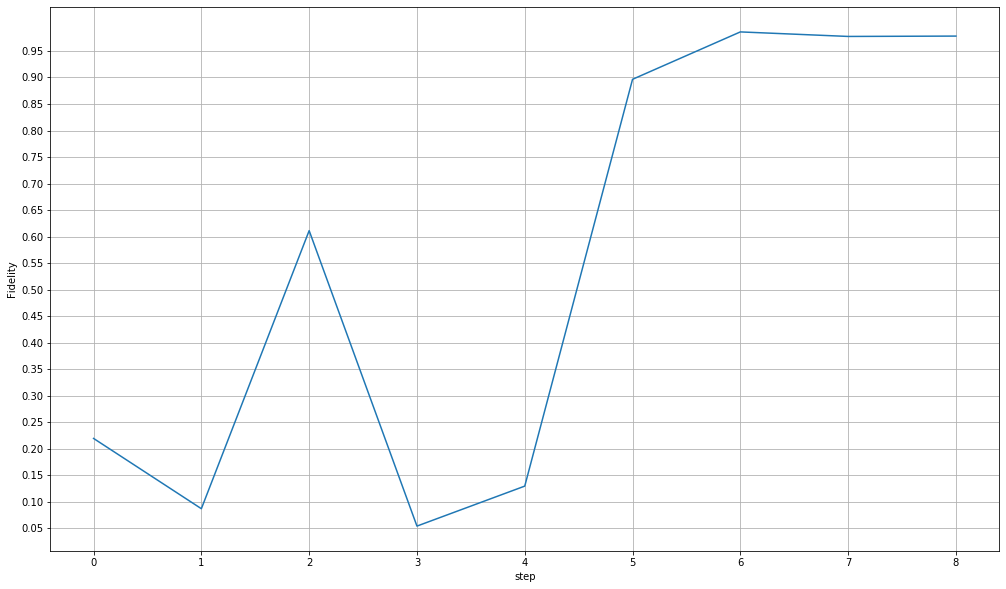

In [3]:
qc.reset()

fidelities_tf = []

signal  = np.array([-0.0018216546513159368, 0.0021649111307008267, 0.00295401791696428, -0.0004872600190229271, -4.7152522857042517e-07, 0.0006462490557820025, -0.001929144421123893, 0.002999860191281257])
signal = signal[0::2] + 1j*signal[1::2]
signal = np.concatenate([signal, [0.]*5])

signal = signal.astype('cdouble')

for action in signal:
    vaction = [np.real(action), np.imag(action)]
    print(vaction)
    obs, reward, episode_over, info = qc.step(tf.constant([vaction]*batch_size))
    fidelities_tf.append(qc.fidelity)
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
plt.xticks(range(len(fidelities_tf)))
plt.grid()
plt.plot(fidelities_tf)
print(f'Fidelity final: {fidelities_tf[-1][0]}')

Fidelity final: 0.9282117486000061
Fidelity max: 0.9435874819755554


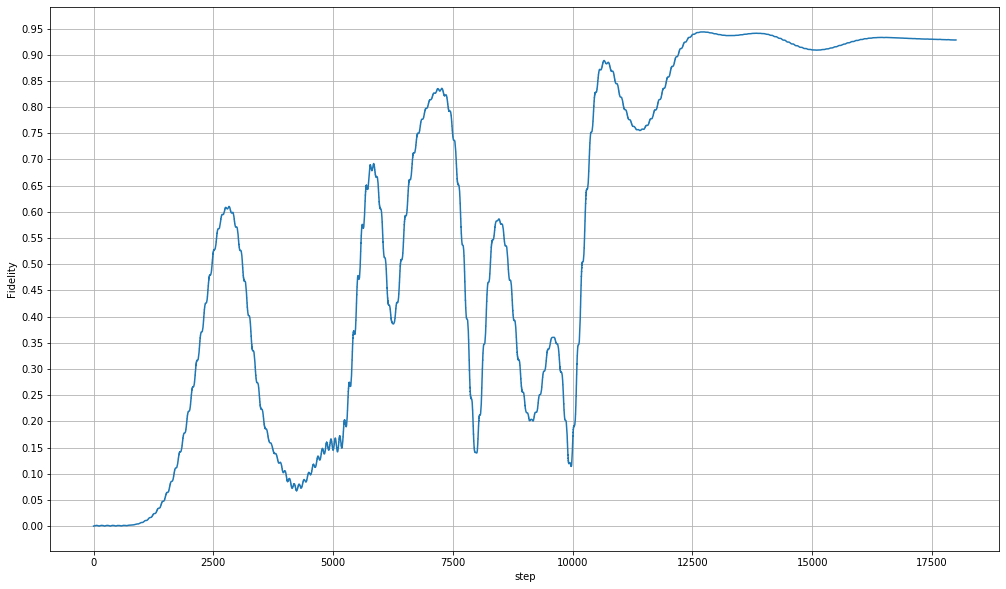

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(17,10))
plt.ylabel('Fidelity')
plt.xlabel('step')
plt.yticks([0.05*i for i in range(20)])
# plt.xticks(range(len(qc.fidelity_history)))
plt.grid()
plt.plot(qc.fidelity_history)
print(f'Fidelity final: {fidelities_tf[-1][0]}')
print(f'Fidelity max: {max(qc.fidelity_history).squeeze()}')

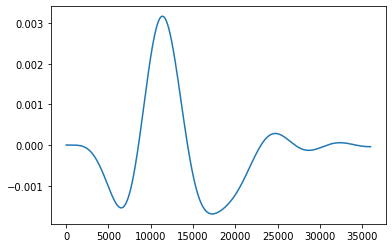

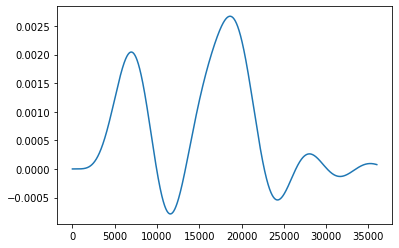

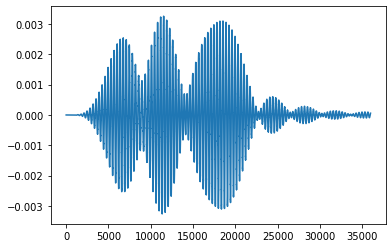

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot([x[0][0] for x in qc.actions_history])
plt.figure()
plt.plot([x[0][1] for x in qc.actions_history])

plt.figure()
plt.plot(qc.gate_drive_history)

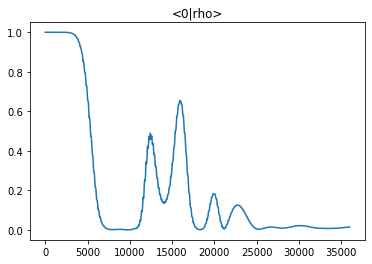

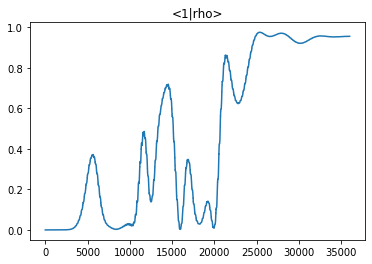

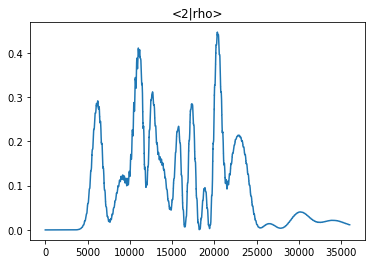

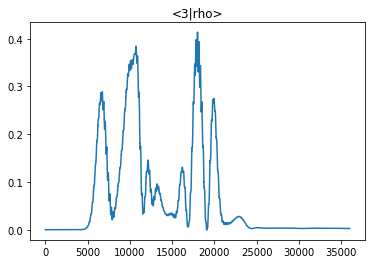

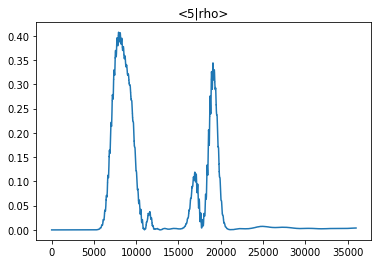

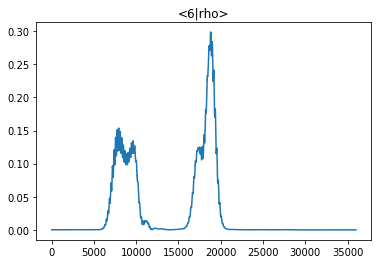

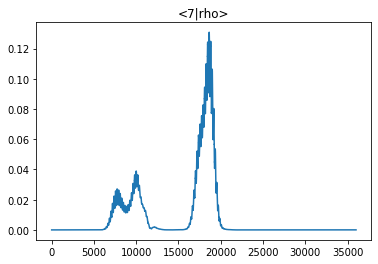

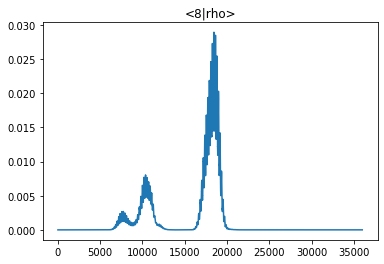

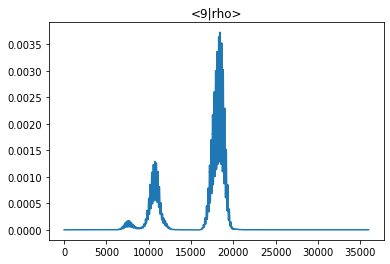

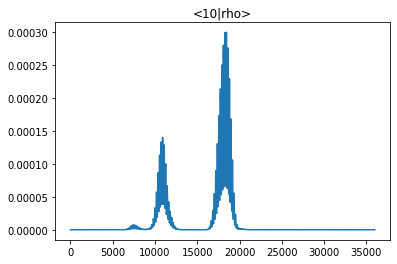

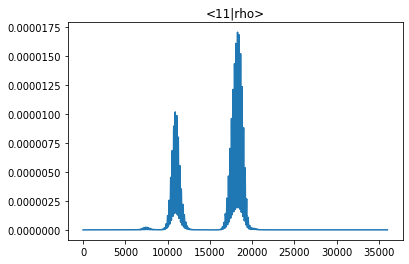

In [6]:
for i in range(qc.fock_space_size):
    plt.figure()
    label = f'<{i}|rho>'
    plt.title(label)
    plt.plot([qs[0][i,i] for qs in qc.qubit_state_history])

In [5]:
qc.f_c

1.119893e-08